In [84]:
import os
import random
from PIL import Image

import torch
from torch import nn
from pathlib import Path
from typing import Tuple, Dict, List
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
print(f"pytorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

pytorch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [86]:
data_path = Path("../dataset/")
image_path = data_path / "data"

In [87]:
# Setup train and testing paths
train_dir = image_path / "train_dir"
test_dir = image_path / "test_dir"

train_dir, test_dir

(WindowsPath('../dataset/data/train_dir'),
 WindowsPath('../dataset/data/test_dir'))

In [88]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [89]:
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None) -> None:
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)

    #make function to load images
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        """ Return total number of samples.
        """
        return len(self.paths)

    def __getitem__(self, index: int):
        """ Returns one sample of data
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [90]:
# Augment train data

train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), 
    transforms.ToTensor() 
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

In [91]:
train_data = ImageFolderCustom(target_dir=train_dir, 
                                      transform=train_transforms)
test_data = ImageFolderCustom(target_dir=test_dir, 
                                     transform=test_transforms)
train_data, test_data

(<__main__.ImageFolderCustom at 0x17b84175c00>,
 <__main__.ImageFolderCustom at 0x17b8419c0d0>)

In [92]:
len(train_data), len(test_data)

(3453, 864)

In [93]:
class_names = train_data.classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [94]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [95]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str]=None,
                          n: int = 10,
                          display_shape: bool=True,
                          seed: int = 42):

    if seed:
        random.seed(seed)

    #get random sample
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 9))

    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

        #adjust image tensor shape for plotting
        #[color_channels, height, width] ->  [height, width,color_channels]
        target_image = target_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(target_image)
        plt.axis(False)
        if classes:
            title = f"class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {target_image.shape}"
        plt.title(title)

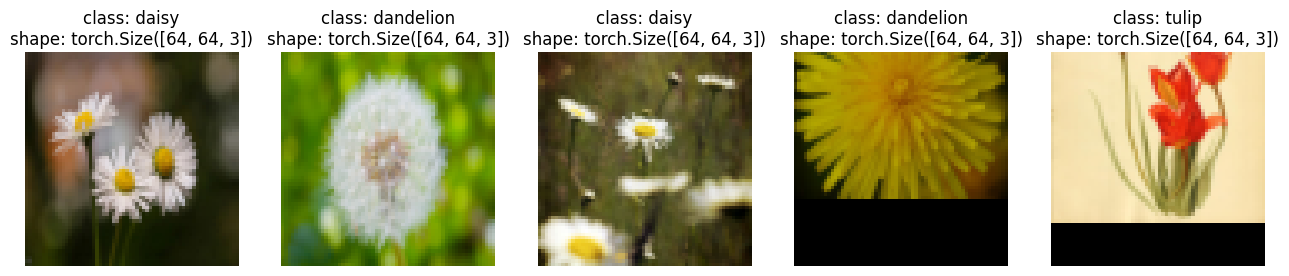

In [96]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=32)

In [97]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                               )

test_dataloader = DataLoader(test_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False, 
                            )

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 16 workers.


(<torch.utils.data.dataloader.DataLoader at 0x17b8432f100>,
 <torch.utils.data.dataloader.DataLoader at 0x17b8432f9d0>)

In [98]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=5, bias=True)
  )
)

In [99]:
#Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

#Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

#Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
#Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0790,  0.0433,  0.0283, -0.0176, -0.0319]])

Output prediction probabilities:
tensor([[0.2119, 0.2045, 0.2015, 0.1924, 0.1897]])

Output prediction label:
tensor([0])

Actual label:
0


In [100]:
from torchinfo import summary

summary(model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [101]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    #train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        #Forward pass
        y_pred = model(X)

     
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        #Optimizer zero grad
        optimizer.zero_grad()

        #Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

      
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [102]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    #eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [103]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [104]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


NUM_EPOCHS = 50

model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5992 | train_acc: 0.2386 | test_loss: 1.5428 | test_acc: 0.2685
Epoch: 2 | train_loss: 1.5277 | train_acc: 0.2928 | test_loss: 1.4525 | test_acc: 0.3229
Epoch: 3 | train_loss: 1.4482 | train_acc: 0.3445 | test_loss: 1.2241 | test_acc: 0.4711
Epoch: 4 | train_loss: 1.2763 | train_acc: 0.4491 | test_loss: 1.1633 | test_acc: 0.5069
Epoch: 5 | train_loss: 1.2473 | train_acc: 0.4767 | test_loss: 1.1431 | test_acc: 0.4965
Epoch: 6 | train_loss: 1.2325 | train_acc: 0.4785 | test_loss: 1.1281 | test_acc: 0.5139
Epoch: 7 | train_loss: 1.2028 | train_acc: 0.4949 | test_loss: 1.0886 | test_acc: 0.5405
Epoch: 8 | train_loss: 1.2023 | train_acc: 0.4996 | test_loss: 1.0875 | test_acc: 0.5532
Epoch: 9 | train_loss: 1.1982 | train_acc: 0.4881 | test_loss: 1.0616 | test_acc: 0.5498
Epoch: 10 | train_loss: 1.1712 | train_acc: 0.5013 | test_loss: 1.0751 | test_acc: 0.5544
Epoch: 11 | train_loss: 1.1764 | train_acc: 0.5085 | test_loss: 1.0684 | test_acc: 0.5787
Epoch: 12 | train_l

In [105]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [106]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend();

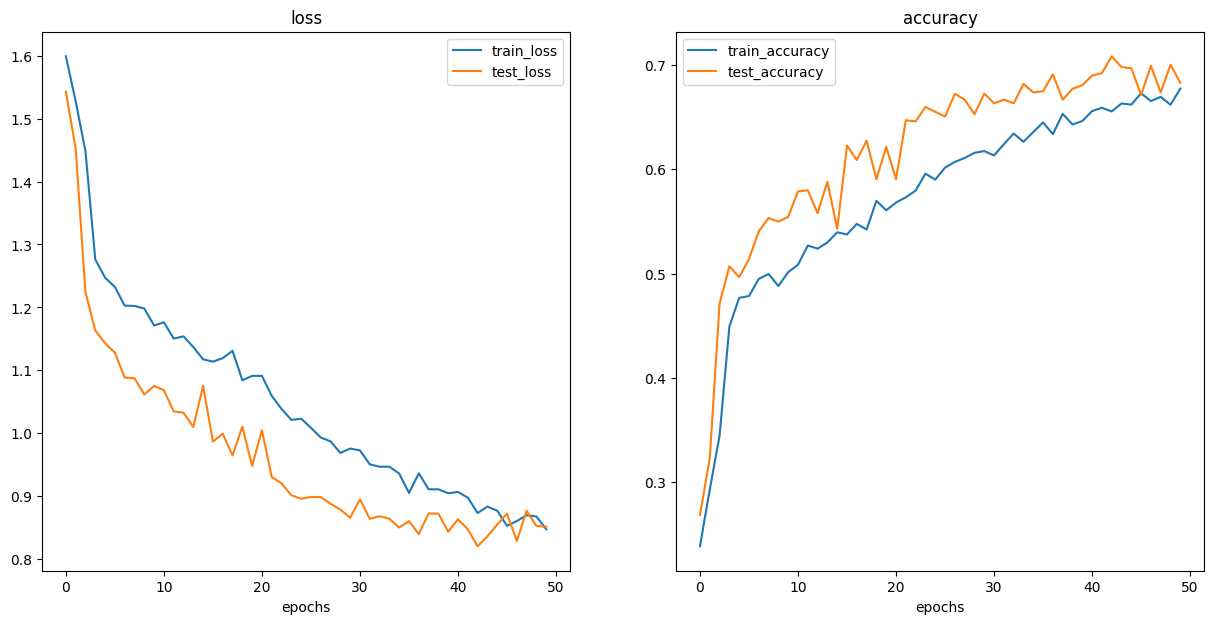

In [107]:
plot_loss_curves(model_0_results)

In [108]:
#custom image path

custom_image_path = "../img/lale.jpg"
print(custom_image_path)

../img/lale.jpg


In [109]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

#divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255

print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 853, 1280])

Custom image dtype: torch.float32


(np.float64(-0.5), np.float64(1279.5), np.float64(852.5), np.float64(-0.5))

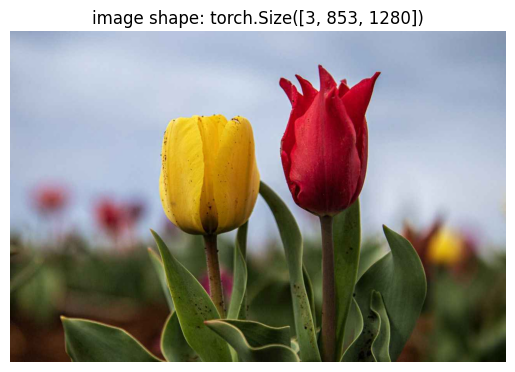

In [110]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"image shape: {custom_image.shape}")
plt.axis(False)

In [111]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

#transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 853, 1280])
New shape: torch.Size([3, 64, 64])


In [112]:
model.eval()
with torch.inference_mode():
    custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")

    custom_image_pred = model(custom_image_transformed).to(device)

Custom image transformed shape: torch.Size([1, 3, 64, 64])


In [113]:
custom_image_pred

tensor([[ 0.0751,  0.0429,  0.0249, -0.0192, -0.0288]])

In [114]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

Prediction probabilities: tensor([[0.2114, 0.2047, 0.2010, 0.1924, 0.1905]])


In [115]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction label: tensor([0])


In [116]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'daisy'